# Avaliação da empresa "Banco do Brasil S.A" (BBAS3)

---



Um modelo de avaliação de ações, conhecido como "valuation", é uma ferramenta que transforma um conjunto de previsões ou observações sobre variáveis da empresa e fatores econômicos em uma estimativa do valor de mercado de uma ação.

As entradas para esse tipo de modelo incluem variáveis econômicas, como lucros futuros, dividendos e flutuações nos lucros, entre outras.

O objetivo é estimar o valor de mercado esperado ou o retorno esperado de manter uma ação, ou fornecer uma recomendação de compra, venda ou manutenção.

Existem diversos métodos de avaliação, cada um usado de maneiras distintas pelas empresas para validar suas premissas. Aqui, vamos utilizar um modelo básico de determinação do preço teórico de uma ação, que considera poucos insumos. Essa abordagem, embora simplificada, é útil para entender o processo de valuation.

Modelo de Fluxo de Caixa Descontado
Os modelos de fluxo de caixa descontado (DCF) baseiam-se na premissa de que o valor de uma ação corresponde ao valor presente dos fluxos de caixa futuros que o acionista espera receber.

Variáveis de Entrada:
SG: Calculada a partir do ROE e Payout obtidos no Yahoo Finance.
CAPM: Com a taxa de referência de swaps DI pré-360 dias como taxa livre de risco, retorno de mercado de 15% ao ano, e beta da ação.
Dividendo Esperado: Média dos dividendos anuais históricos da BBAS3.
Com essas variáveis, podemos implementar o modelo de crescimento constante no Python para calcular o preço teórico da ação.

In [ ]:
! pip install ipeadatapy

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import ipeadatapy as ip
from plotnine import *

# Taxa de Crescimento (g):

In [ ]:
ticker = "BBAS3.SA"
price = yf.download(ticker, period = '1d')['Adj Close']
price.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2024-09-04,28.99


In [ ]:
data = yf.Ticker(ticker)
dividends = data.dividends
dividends.head()

,Dividends
Date,
2009-06-23 00:00:00-03:00,0.090111
2009-08-14 00:00:00-03:00,0.095437
2009-09-22 00:00:00-03:00,0.092699
2009-11-13 00:00:00-02:00,0.061449
2009-12-22 00:00:00-02:00,0.094522


In [ ]:
# Calculo do g:

g = data.info['returnOnEquity']*(1-data.get_info()['payoutRatio'])
g

0.1483500075

Taxa exigida pelos investidores:

In [ ]:
# beta fornecido pelo Yahoo

beta = data.info['beta']

juros_livre = (
    ip.timeseries('BMF12_SWAPDI36012')
    .rename(columns = {'VALUE ((% a.a.))' : 'swaps'})[['swaps']]
    .div(100)
    .iloc[-1]
    .swaps
  )

juros_livre

retorno = 0.125


# Cálculo do r:
---

In [ ]:
# calcula o custo do capital
r = juros_livre + beta * (retorno - juros_livre)
r

0.11885779090909088

In [ ]:
anual_dividendos = (
    pd.DataFrame(dividends)
    .tz_localize(None)
    .assign(Year = lambda x: x.index.year)
    .groupby(['Year']) # agrupa por ano
    .agg({'Dividends' : 'sum'}) # soma os dividendos do ano
    .iloc[:-1]
)

anual_dividendos

,Dividends
Year,
2009,0.434218
2010,0.893389
2011,0.928628
2012,0.812912
2013,1.188493
2014,0.830012
2015,1.030820
2016,0.456858
2017,0.472985


# Gerando o gráfico de dividendos:
---

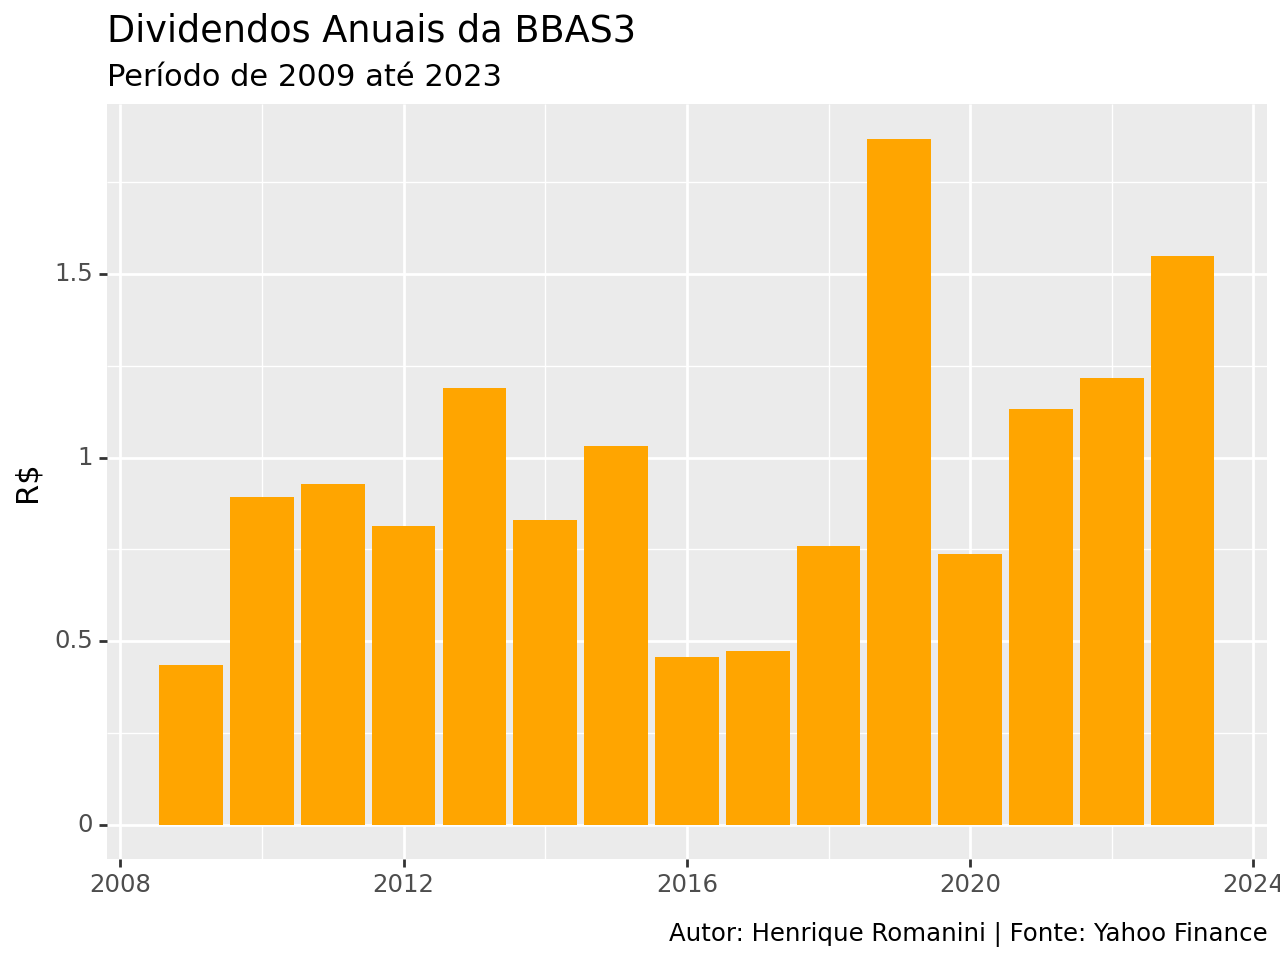

<Figure Size: (640 x 480)>

In [ ]:
anual_dividendos_reindex = anual_dividendos.reset_index()

(ggplot(anual_dividendos_reindex, aes(x = 'Year', y = "Dividends"))
  + geom_col(fill = 'orange')
  + labs(title = 'Dividendos Anuais da BBAS3', subtitle = "Período de 2009 até 2023",
         caption = "Autor: Henrique Romanini | Fonte: Yahoo Finance",
         x = "",
         y = "R$"))

# Comparando o preço teórico com o valor atual:

In [ ]:
D_esperado = anual_dividendos.mean().Dividends

# Calculando o valor presente líquido da ação (PV)
PV = D_esperado / (g - r)

print(f"Valor presente da ação {ticker}: R$ {PV:.2f}")
print(f"Valor da ação {ticker}: R$ {price.values[0]:.2f}")

Valor presente da ação BBAS3.SA: R$ 32.35
Valor da ação BBAS3.SA: R$ 28.99


Considerando o resultado final, concluimos que as ações do Banco do Brasil S.A estão abaixo do valor de mercado de acordo o método utilizado

Agora faremos uma análise para avaliar o futuro dessa ação baseada na análise de séries temporais:

# Série temporal
---


In [ ]:
! pip install Prophet

In [ ]:
from prophet import Prophet

Agora importaremos o valor da BBAS3 nos ultimos 24 meses

In [ ]:
prices = yf.download(ticker, period = '2y')["Adj Close"].reset_index()
prices.columns = ["ds", "y"]
prices.head()

[*********************100%***********************]  1 of 1 completed


,ds,y
0,2022-09-05,18.044584
1,2022-09-06,17.177679
2,2022-09-08,17.103992
3,2022-09-09,17.576454
4,2022-09-12,17.849531


Usando a biblioteca Phophet avaliaremos o comportamento futuro por meio das séries temporais. Treinaremos o modelo e verificaremos as probabilidades de retorno a longo prazo.

In [ ]:
model = Prophet()
model.fit(prices)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjd_k7_rp/c5d4sm0h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjd_k7_rp/et5_i7iw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75845', 'data', 'file=/tmp/tmpjd_k7_rp/c5d4sm0h.json', 'init=/tmp/tmpjd_k7_rp/et5_i7iw.json', 'output', 'file=/tmp/tmpjd_k7_rp/prophet_modelpjktgl0f/prophet_model-20240905131530.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:15:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:15:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
previsoes = model.make_future_dataframe(periods = 365)
previsoes.tail()

,ds
860,2025-08-31
861,2025-09-01
862,2025-09-02
863,2025-09-03
864,2025-09-04


In [ ]:
st = model.predict(previsoes)

st = st.rename(columns = {'ds' : 'data', 'yhat' : 'Preço BBAS3', 'yhat_lower' : 'Lower', 'yhat_upper' : 'Upper'})

st.tail()

,data,trend,Lower,Upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,Preço BBAS3
860,2025-08-31,35.223467,19.914911,47.572578,21.238666,48.714146,-1.285072,-1.285072,-1.285072,-0.492697,-0.492697,-0.492697,-0.792376,-0.792376,-0.792376,0.0,0.0,0.0,33.938394
861,2025-09-01,35.241025,20.402539,48.115473,21.198255,48.754224,-0.594196,-0.594196,-0.594196,0.194549,0.194549,0.194549,-0.788745,-0.788745,-0.788745,0.0,0.0,0.0,34.646830
862,2025-09-02,35.258584,20.402782,48.238150,21.116378,48.831397,-0.613486,-0.613486,-0.613486,0.178139,0.178139,0.178139,-0.791625,-0.791625,-0.791625,0.0,0.0,0.0,34.645098
863,2025-09-03,35.276143,20.397731,48.379636,21.059176,48.914998,-0.597937,-0.597937,-0.597937,0.202758,0.202758,0.202758,-0.800695,-0.800695,-0.800695,0.0,0.0,0.0,34.678206
864,2025-09-04,35.293702,20.285865,48.345783,21.026067,48.995916,-0.625293,-0.625293,-0.625293,0.190205,0.190205,0.190205,-0.815498,-0.815498,-0.815498,0.0,0.0,0.0,34.668409


A seguir o gráfico com as previsões:

In [ ]:
(ggplot(st, aes(dx = 'data', yhat = 'Preço BBAS3')) + geom_point() + geom_line()
  + labs(title = 'Previsão da BBAS3',
         caption = "Autor: Henrique Romanini | Fonte: Yahoo Finance",
         x = "",
         y = "R$"))

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result


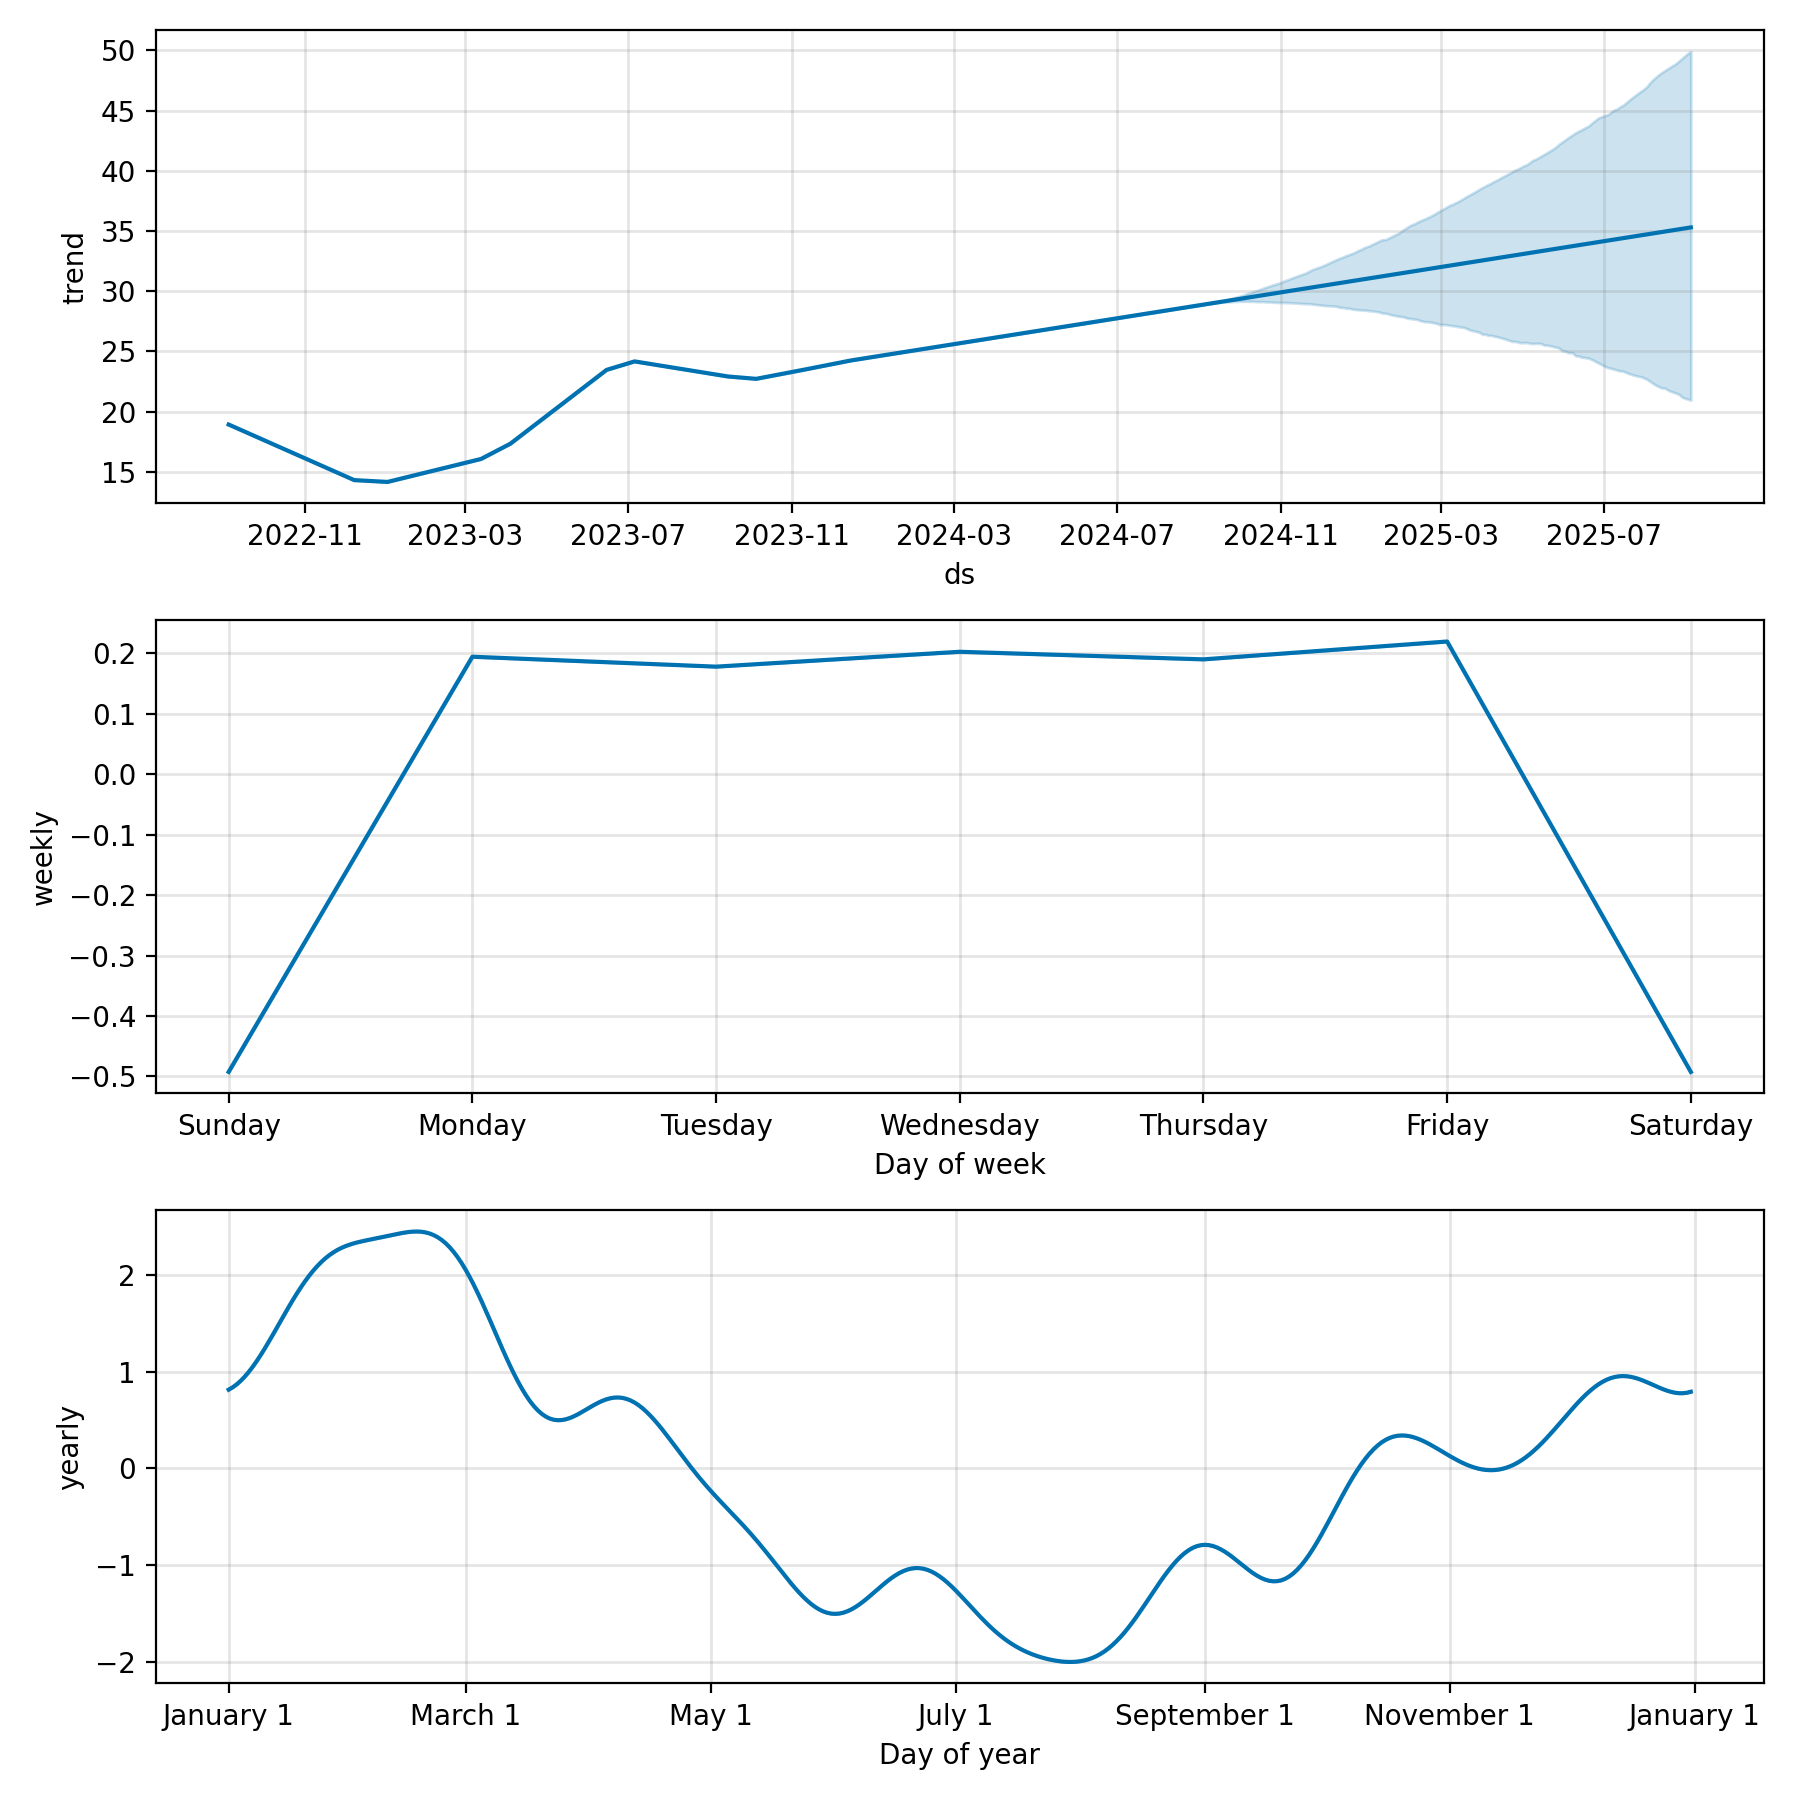

In [ ]:
graph2 = model.plot_components(st)